# New Analysis (2017-02-16)

This is a project for testing various text mining and machine learning technologies. It can be adapted to a production for new classification and analysis.

* Initail data source: "Trade News Today" emails
* Reference of techniques and code:
    * [Document Clustering with Python](http://brandonrose.org/clustering) (orginal code was kept as original as possible).
* Classification
    * Use unsuperized learning, clustering and topic model, to classify news articles into categories
    * Classified data could be used as traing data for classifiction models (different algritoms)
    * Classification model could be used classify news flow into categories
* Topic model: use topic model to identify keywords, then use keywords to summarize new data(?)
* Sentiment analysis

## Content

_**To finish later**_


* [Data extraction, cleaning](#Data-extraction,-cleaning)
    * [Convert emails to TXT files](#Convert-emails-to-TXT-files)
    * [Extract articles from a TXT file and convert to DF](#Extract-articles-from-a-TXT-file-and-convert-to-DF)
    
* Document Clustering with Python
    * [Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
    * [Tf-idf and document similarity](#Tf-idf-and-document-similarity)
    * [K-means clustering](#K-means-clustering)
    * [Multidimensional scaling](#Multidimensional-scaling)
    * [Visualizing document clusters](#Visualizing-document-clusters)
    * [Hierarchical document clustering](#Hierarchical-document-clustering)
    * [Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)


In [3]:
import pandas as pd
# import datefinder
# import numpy as np
# import win32com.client
# import codecs
# import os
# import re
#import itertools

## Data extraction and cleaning

The process of extracting articles from emails is done outside this notebook by using Spader-python code. The processing includes:

**Step 1. Convert Outlook emails to text files**
* Emails should be under Outlook folder "@ News" >> "2015"
* Code can only run on office computer with outlook access
* Code only needs to be run once for a set of emails (say for emails in 2015)
* Text files are saved with ASCII coding instead of UTF-8

**Step 2. Extract articles from a TXT file and convert to DF** 
* Extractor read and parse a TXT file.
* Titles of news are listed on the top of email as an index. Extractor matches headings in index with each title above article bodies to identify individual article.
* There will be some articles having problems to match: modify TXT files and correct irregular texts, then run this process again until all matching done properly.
* Progress: data done: 2015 and 2016

**Step 3. Additional processing**
* Detect language
* Add date
* Detect new agency

Read data from pck generated by Spyder-Python

In [4]:
df = pd.read_pickle('df_save.pck')
df.head()

,Date,ArticleCode,Language,Title,Content
0,2015-01-05,1,en,WTO celebrates 20 years of helping global econ...,"GENEVA, Jan 1 (KUNA) -- The World Trade Organi..."
1,2015-01-05,2,fr,L'Organisation mondiale du commerce l'preuve d...,5 January 2015 Les Echos L'OMC s'est donn six ...
2,2015-01-05,3,en,"Delegates of 45 nations,WTO Chief to be at CII...","New Delhi, Jan 2 (PTI) Over 1,000 delegates fr..."
3,2015-01-05,4,en,"Compliance Rulings On Aircraft, Tuna, COOL To ...","World Trade Online Posted: December 30, 2014 A..."
4,2015-01-05,5,en,Sudan making new push at WTO membership: official,"Sudan Tribune 4 January 2015 January 3, 2015 (..."


Possible additional processing used in the data analysis process below. Some could be transfer to Spyder-Python program

In [5]:
df = df[df['Language'].isin(['en'])]
# Combine title and contents
df['Text'] = df['Title'] + ' ' + df['Content']

In [6]:
df[df['Text'].str.contains('S.Korea')].head()

,Date,ArticleCode,Language,Title,Content,Text
12,2015-01-06,1,en,S.Korea says imposes rice import tariff of ove...,"SEOUL, Jan 6 (Reuters) - South Korea confirmed...",S.Korea says imposes rice import tariff of ove...
171,2015-01-21,9,en,S.Korea to levy anti-dumping duty on Japan's p...,"[e]Yoo Seungki SEOUL, Jan. 21 (Xinhua) -- Sout...",S.Korea to levy anti-dumping duty on Japan's p...
770,2015-03-18,9,en,U.S. sets preliminary duties on Turkey pipe im...,"WASHINGTON, March 17 (Reuters) - The United St...",U.S. sets preliminary duties on Turkey pipe im...
2942,2015-11-02,4,en,"China, Japan, S Korea agree to boost trade, wo...",2 November 2015 TODAY (Singapore) SEOUL In a s...,"China, Japan, S Korea agree to boost trade, wo..."
3899,2016-02-15,10,en,S.Korea says time for more G20 policy coordina...,"15 February 2016 Reuters News SEOUL, Feb 15 (R...",S.Korea says time for more G20 policy coordina...


In [7]:
# Normalize words

replacements = {
    'Text': {
        r'\'s': '', 
        'Indian': 'India', 
        'nextgeneration': 'next generation', 
        '//iconnect\.wto\.org/': '', 
        '-': ' ', 
        'U.S.': 'United States', 
        'US': 'United States', 
        'S.Korea': 'South Korea', 
        'S. Korea': 'South Korea', 
        'WTO': 'world trade organization', 
        '‘': '', 
        'imports': 'import', 
        'Imports': 'import', 
        'exports': 'export', 
        'Exports': 'export', 
        'NZ ': 'New Zealand ', 
        '\"': '',
        '\'': '', 
    }
}

df.replace(replacements, regex=True, inplace=True)


In [8]:
# Test
df[df['Text'].str.contains('S.Korea')].head()

,Date,ArticleCode,Language,Title,Content,Text


Convert DF to lists

In [9]:
texts = df['Text'].tolist()
titles = df['Title'].tolist()
dates = df['Date'].tolist()
articlecodes = df['ArticleCode'].tolist()

In [10]:
print(str(len(texts)) + ' texts')
print(str(len(titles)) + ' titles')
print(str(len(dates)) + ' dates')
print(str(len(articlecodes)) + ' articlecodes')

6409 texts
6409 titles
6409 dates
6409 articlecodes


## Analysis

### Original Notes
<img src='header_short.jpg'>

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the example. This guide covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

### Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

In [11]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

# Stopwords, stemming, and tokenizing

**Stopwords**

Load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. 

In [13]:
# load nltk's English stopwords as variable called 'stopwords'
my_stop_words = nltk.corpus.stopwords.words('english')

# Add my stopwords
my_stop_words = my_stop_words + ['world_trade_organization','years','year','said','important',
                                 'new','would','','','','']

# Stopwords of country names  NOT WORKING ????
#my_stop_words = my_stop_words + ['world_trade_organization','years','year','said','important','new','would','united_states',
#                                   'japan','india','obama','canada','mexico','russia','eu','european','china','chinese','would']

**MWETokenizer being able to attach words together**

In [35]:
from nltk.tokenize import MWETokenizer
tokenizer = MWETokenizer([('world', 'bank'), ('world', 'trade', 'organization'), ('doha', 'round'),
                          ('united', 'states'), ('european', 'union'), ('new', 'zealand'),
                          ('per', 'cent'),('south', 'korea'),
                          ])

# Test the tokenizer
tokenizer.tokenize('In a little or a european union little bit world trade organization'.split())


['In',
 'a',
 'little',
 'or',
 'a',
 'european_union',
 'little',
 'bit',
 'world_trade_organization']

In [ ]:
# Test the function
#tokenize_and_stem('In World Bank or a_little. bit  _ World Trade Organization. United States')

## load nltk's SnowballStemmer as variabled 'stemmer'
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer("english")


In [ ]:
# Use WordNetLemmatizer instead of stemmer
#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()
#df['Lemmatized'] = df['StopRemoved'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])


Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [12]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [14]:
# ORIGINAL CODE
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [18]:
# Define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # Remove punctuation
#    text = text.translate(str.maketrans('','',string.punctuation))

    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
#    tokens = [word for sent in nltk.sent_tokenize(text) for word in tokenizer.tokenize(sent.lower().split())]
    
    # MWETokenizer: manually link words, when disabled, use n-gram range in TF-IDF
#    tokens = tokenizer.tokenize(text.lower().split())
    tokens = tokenizer.tokenize(tokens)

    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if (re.search('[a-zA-Z]', token)): 
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    # WordNetLemmatizer
#    stems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # Remove punctuation
#    text = text.translate(str.maketrans('','',string.punctuation))

    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
#    tokens = [word for sent in nltk.sent_tokenize(text) for word in tokenizer.tokenize(sent.lower().split())]
    
    # MWETokenizer: manually link words, when disabled, use n-gram range in TF-IDF
#    tokens = tokenizer.tokenize(text.lower().split())
    tokens = tokenizer.tokenize(tokens)

    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if (re.search('[a-zA-Z]', token)): 
            filtered_tokens.append(token)
    stems = filtered_tokens
#    stems = [stemmer.stem(t) for t in filtered_tokens]
    # WordNetLemmatizer
#    stems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return stems


Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [21]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in texts:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [22]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [30]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 3744650 items in vocab_frame


You'll notice there is clearly some repetition here. I could clean it up, but there are only 312209 items in the DataFrame which isn't huge overhead in looking up a stemmed word based on the stem-index.

In [23]:
vocab_frame.head(29)

,words
world_trade_organ,world_trade_organization
celebr,celebrates
year,years
of,of
help,helping
global,global
economi,economy
grow,grow
geneva,GENEVA
jan,Jan


## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

print(tfidf_matrix.shape)

Wall time: 1min 49s
(6409, 157)


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                   min_df=0.1, stop_words=my_stop_words, 
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

print(tfidf_matrix.shape)


Wall time: 1min 55s
(6409, 546)


*terms* is just a list of the features used in the tf-idf matrix. This is a vocabulary

In [33]:
terms = tfidf_vectorizer.get_feature_names()

In [34]:
terms

['abl',
 'accept',
 'access',
 'accord',
 'account',
 'achiev',
 'across',
 'act',
 'action',
 'activ',
 'ad',
 'addit',
 'address',
 'administr',
 'adopt',
 'advanc',
 'affect',
 'africa',
 'agenc',
 'agenda',
 'ago',
 'agre',
 'agreement',
 'agricultur',
 'ahead',
 'aim',
 'allow',
 'almost',
 'alreadi',
 'also',
 'although',
 'america',
 'american',
 'among',
 'ani',
 'announc',
 'annual',
 'anoth',
 'anti',
 'appli',
 'approach',
 'approv',
 'april',
 'area',
 'argu',
 'around',
 'asia',
 'asian',
 'ask',
 'associ',
 'august',
 'australia',
 'author',
 'back',
 'bank',
 'barrier',
 'base',
 'becaus',
 'becom',
 'befor',
 'beij',
 'believ',
 'benefit',
 'best',
 'better',
 'big',
 'biggest',
 'bilater',
 'billion',
 'bodi',
 'boost',
 'border',
 'brazil',
 'bring',
 'build',
 'busi',
 'call',
 'campaign',
 'canada',
 'capit',
 'case',
 'caus',
 'central',
 'certain',
 'challeng',
 'chang',
 'chief',
 'china',
 'chines',
 'claim',
 'clear',
 'close',
 'come',
 'comment',
 'commerc',


*dist* is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with *dist* it is possible to evaluate the similarity of any two or more synopses.

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [27]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

Wall time: 43.4 s


I use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [38]:
from sklearn.externals import joblib

# joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [42]:
df_tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray())
# df_tfidf_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,536,537,538,539,540,541,542,543,544,545
0,0.000000,0.0,0.000000,0.043421,0.061231,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.065230,0.000000,0.0,0.000000,0.442808,0.066492,0.000000,0.066851,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.041812,0.000000,0.0,0.000000,0.087334,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.034595,0.000000,0.000000,0.0,0.0,0.025454,0.0,...,0.0,0.012992,0.019214,0.0,0.000000,0.122121,0.000000,0.140731,0.000000,0.024336
3,0.057634,0.0,0.084952,0.070405,0.000000,0.053947,0.0,0.0,0.000000,0.0,...,0.0,0.026442,0.039103,0.0,0.052081,0.552296,0.000000,0.114563,0.054197,0.049527
4,0.000000,0.0,0.000000,0.060269,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.090539,0.000000,0.0,0.000000,0.141834,0.000000,0.196138,0.000000,0.000000


Here, I create a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre [rank and genre were scraped from IMDB].

I convert this dictionary to a Pandas DataFrame for easy access. I'm a huge fan of [Pandas](http://pandas.pydata.org/) and recommend taking a look at some of its awesome functionality which I'll use below, but not describe in a ton of detail.

In [43]:
news = {'date': dates,'articlecode': articlecodes, 'title': titles,'text': texts,'cluster': clusters}
frame = pd.DataFrame(news, index = [clusters], columns = ['date','articlecode','title','text','cluster'])

In [44]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

# Export to Access to analyze clusters
# frame.to_csv('newsclusters.txt', sep='^')

1    2429
2    1439
0    1052
3     755
4     734
Name: cluster, dtype: int64

Here is some fancy indexing and sorting on each cluster to identify which are the top *n* (I chose *n*=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [47]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
#     print("Cluster %d titles:" % i, end='')
#     for title in frame.ix[i]['title'].values.tolist():
#         print(' %s,' % title, end='')
#     print()
#     print()

Top terms per cluster:

Cluster 0 words: b'ago', b'agreed', b'domestic', b'decision', b'changes', b'arguing',

Cluster 1 words: b'domestic', b'decision', b'although', b'economic', b'before', b'any',

Cluster 2 words: b'economic', b'decision', b'Chinese', b'although', b'anti', b'account',

Cluster 3 words: b'boost', b'economic', b'domestic', b'decision', b'although', b'anti',

Cluster 4 words: b'Asian', b'asks', b'any', b'decision', b'Commerce', b'domestic',



In [ ]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

# Multidimensional scaling

Here is some code to convert the dist matrix into a 2-dimensional array using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling). I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use [principal component analysis](http://en.wikipedia.org/wiki/Principal_component_analysis). 

In [48]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [49]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js). 

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [50]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

Next, I plot the labeled observations (films, film titles) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

In [51]:
%matplotlib inline

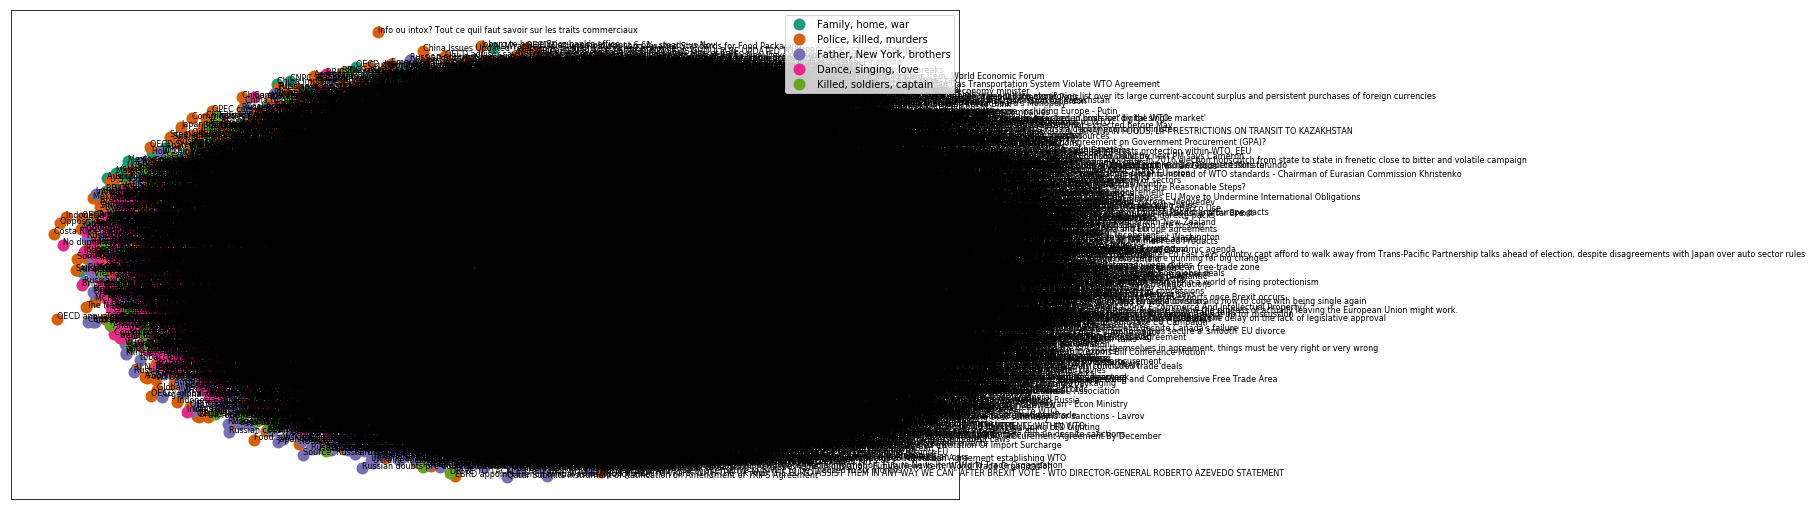

In [52]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [52]:
plt.close()

The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with [D3.js](http://d3js.org/) I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon [mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [57]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

Here is the actual creation of the interactive scatterplot. I won't go into much more detail about it since it's pretty much a straightforward copy of one of the mpld3 examples, though I use a pandas groupby to group by cluster, then iterate through the groups as I layer the scatterplot. Note that relative to doing this with raw D3, mpld3 is much simpler to integrate into your Python workflow. If you click around the rest of my website you'll see that I do love D3, but for basic interactives I will probably use mpld3 a lot going forward.

Note that mpld3 lets you define some custom CSS, which I use to style the font, the axes, and the left margin on the figure.

In [58]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

Now that I was successfuly able to cluster and plot the documents using k-means, I wanted to try another clustering algorithm. I chose the [Ward clustering algorithm](http://en.wikipedia.org/wiki/Ward%27s_method) because it offers hierarchical clustering. Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. I used the precomputed cosine distance matrix (*dist*) to calclate a linkage_matrix, which I then plot as a dendrogram. 

Note that this method returned 3 primary clusters, with the largest cluster being split into about 4 major subclusters. Note that the cluster in red contains many of the "Killed, soldiers, captain" films. *Braveheart* and *Gladiator* are within the same low-level cluster which is interesting as these are probably my two favorite movies.

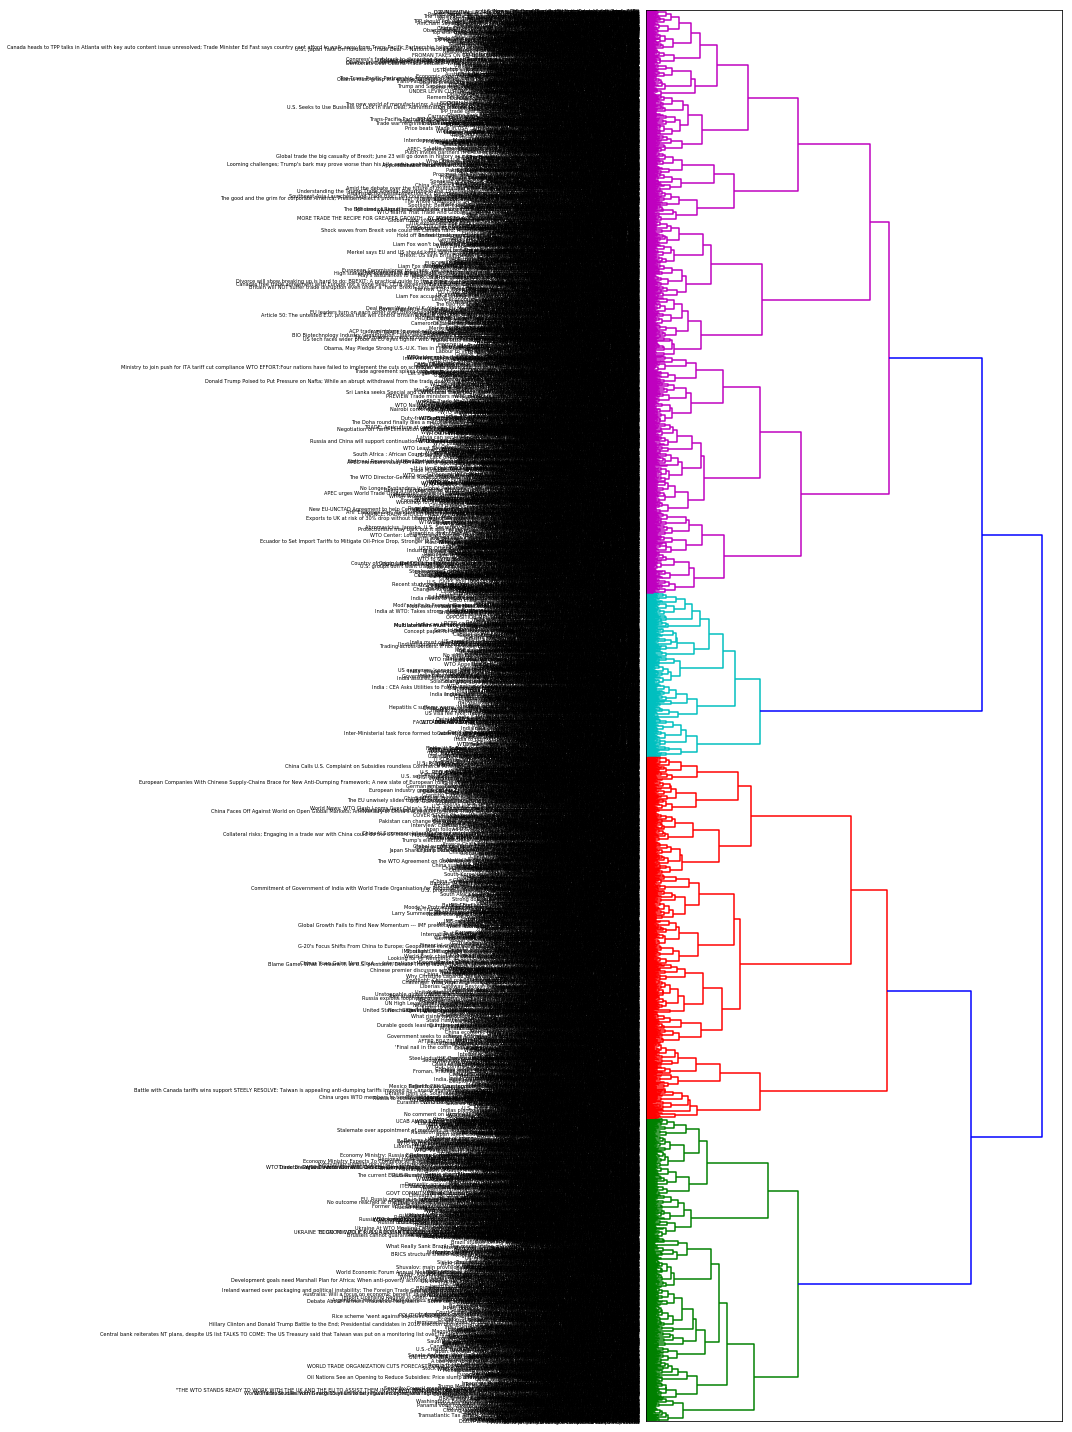

In [60]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [ ]:
plt.close()

# Latent Dirichlet Allocation

This section focuses on using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. There is quite a good high-level overview of probabilistic topic models by one of the big names in the field, David Blei, available in the [Communications of the ACM here](http://delivery.acm.org/10.1145/2140000/2133826/p77-blei.pdf?ip=68.48.185.120&id=2133826&acc=OPEN&key=4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E6D218144511F3437&CFID=612398453&CFTOKEN=48760790&__acm__=1419436704_2d47aefe0700e44f81eb822df659a341). Incidentally, Blei was one of the authors of the seminal paper on LDA.

For my implementaiton of LDA, I use the [Gensim pacakage](https://radimrehurek.com/gensim/). I'm going to preprocess the synopses a bit differently here, and first I define a function to remove any proper noun.

In [61]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

Since the above function is just based on capitalization, it is prone to remove words at the beginning of sentences. So, I wrote the below function using NLTK's part of speech tagger. However, it took way too long to run across all synopses, so I stuck with the above.

In [62]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

Here I run the actual text processing (removing of proper nouns, tokenization, removal of stop words)

In [65]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in texts]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in my_stop_words] for text in tokenized_text]

Wall time: 1min 2s
Wall time: 6.4 s


In [66]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

190


Below are some Gensim specific conversions; I also filter out extreme words (see inline comment)

In [67]:
dictionary = corpora.Dictionary(texts)

In [68]:
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [69]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [70]:
len(corpus)

6409

The actual model runs below. I took 100 passes to ensure convergence, but you can see that it took my machine 13 minutes to run. My chunksize is larger than the corpus so basically all synopses are used per pass. I should optimize this, and Gensim has the capacity to run in parallel. I'll likely explore this further as I use the implementation on larger corpora.

In [ ]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

In [ ]:
%time lda = models.LdaModel(corpus, num_topics=5, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=10000, 
                            passes=100)

Each topic has a set of words that defines it, along with a certain probability.

In [ ]:
lda.show_topics()

In [140]:
print(lda[corpus[0]])

[(1, 0.14010786617821663), (2, 0.2389980721391618), (3, 0.080853026271803449), (4, 0.53991713521730689)]


In [141]:
topics = lda.print_topics(5, num_words=20)

Here, I convert the topics into just a list of the top 20 words in each topic. You can see a similar breakdown of topics as I identified using k-means including a war/family topic and a more clearly war/epic topic.

In [143]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [144]:
topics_matrix = np.array(topics_matrix)

In [145]:
topics_matrix.shape

(5, 20, 2)

In [146]:
topic_words = topics_matrix[:,:,1]

In [147]:
for i in topic_words:
    print([str(word) for word in i])
    print()

['famili', 'murder', 'prison', 'work', 'kill', 'life', 'guard', 'way', "n't", 'two', 'meet', 'would', 'death', 'say', 'll', 'vote', 'becom', 'ask', 'guilti', 'peopl']

['love', 'marri', 'go', 'home', 'friend', 'show', 'day', 'father', 'meet', 'want', "n't", 'night', 'doe', 'apart', 'famili', 'work', 'film', 'first', 'sing', 'come']

['kill', 'meet', 'arriv', 'first', 'two', 'order', 'escap', 'friend', 'say', 'famili', 'ask', 'call', 'attempt', 'father', 'later', 'refus', "n't", 'offer', 'name', 'away']

['kill', 'soldier', 'men', 'order', 'shark', 'command', 'attack', 'water', 'war', 'offic', 'arriv', 'boat', 'die', 'wound', 'two', 'attempt', 'villag', 'fire', 'battl', 'shoot']

['car', 'ask', 'polic', 'home', "n't", 'go', 'say', 'kill', 'run', 'hous', 'goe', 'two', 'friend', 'day', 'call', 'come', 'drive', 'meet', 'doe', 'away']

